<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20

### First name:   Stanislav
### Second name:   Ilyushin
### Group:   мИИПИ22

## Task 1 (3 points)

Consider the following toy dataset:

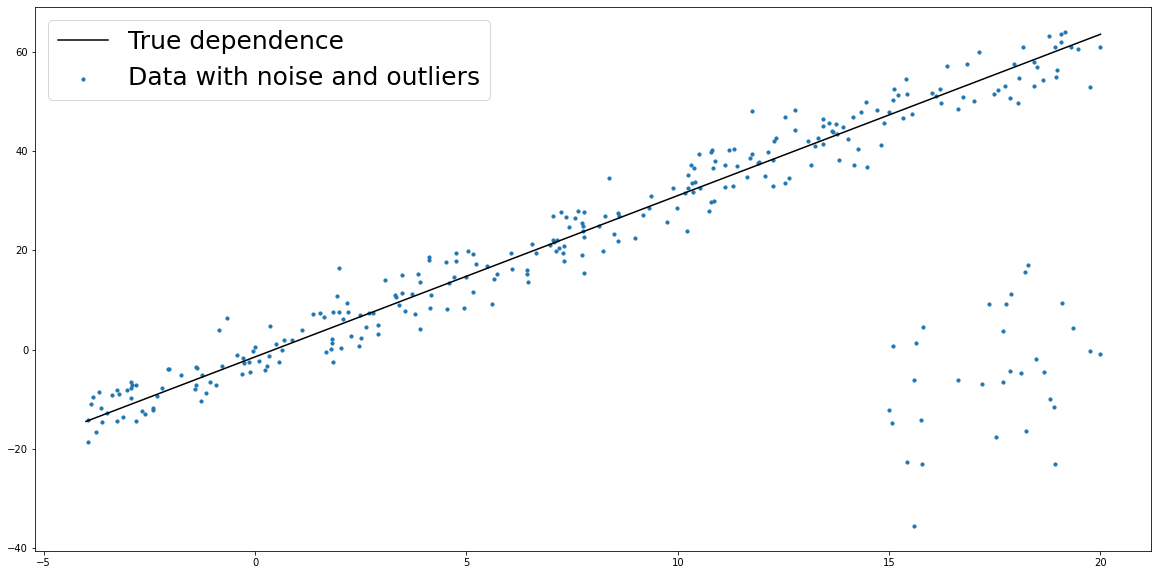

In [2]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
    x = np.random.uniform(*limits, size=N)
    y = true_function(x) + noize_function(x)

    return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend(loc=2, prop={'size': 25});

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

$$Loss(w,b) = \sum_{i=1}^{n}|y_i - (w^Tx_i+b)| \to min_{w,b}$$

$$\frac{\partial Loss(w,b)}{\partial w} = \begin{cases}
 & \text{-sign(x) if } y_i - \hat{y} > 0 \\
 & \text{sign(x) if } y_i - \hat{y} < 0
\end{cases}$$

$$\frac{\partial Loss(w,b)}{\partial b} = \begin{cases}
 & \text{-1 if } y_i - \hat{y} > 0 \\
 & \text{1 if } y_i - \hat{y} < 0
\end{cases}$$

In [3]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.absolute(y_true - predictions))

In [4]:
def gradient_discent_linear(X, y, lr):
    ungen = np.random.RandomState(2020)
    weights = ungen.uniform(-np.sqrt(6)/np.sqrt(2*X.shape[0]), +np.sqrt(6)/np.sqrt(2*X.shape[0]), size = 1 + X.shape[1])
    # xavier init (in, out) = (300,300)
   
    costs =[]
    for i in range(400):
        net_input = np.dot(X, weights[1:])+weights[0]
        output = np.clip(net_input, -100, 100) # exploading gradient problem (light fix)
        errors = (y-output)
        weights[1:] += lr * X.T.dot(np.sign(errors))
        weights[0] += lr * np.mean(np.sign(errors))
        cost = mae(y, output)
        costs.append(cost)
        
    return weights[0], weights[1:], costs
   

In [5]:
constant, angle, costs = gradient_discent_linear(X, y, lr = 1e-5)

In [6]:
lin_reg = LinearRegression().fit(X, y)
constant_sk = lin_reg.intercept_
angle_sk = lin_reg.coef_

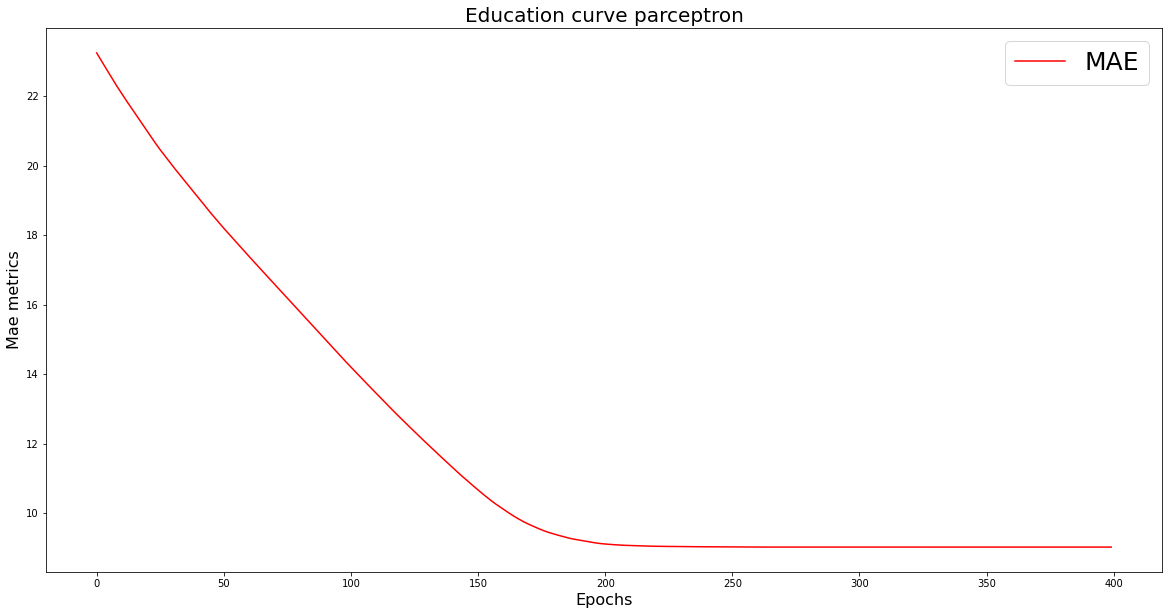

In [7]:
plt.plot(list(range(len(costs))), costs, c='red', label='MAE')
plt.title("Education curve parceptron")
plt.xlabel("Epochs")
plt.ylabel("Mae metrics")
plt.legend(loc=1, prop={'size': 25})
plt.show()

In [8]:
predict_function = lambda x: angle* x + constant
predict_function_sklearn = lambda x: angle_sk* x + constant_sk

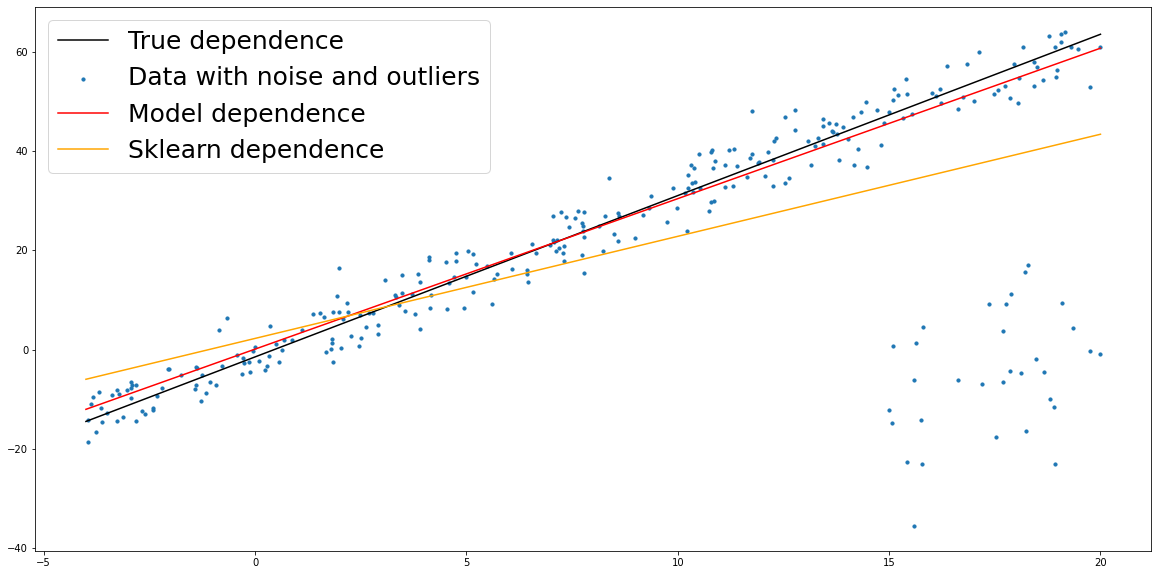

In [9]:
x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, predict_function(x), c='red', label='Model dependence')
plt.plot(x, predict_function_sklearn(x), c='orange', label='Sklearn dependence')
plt.legend(loc=2, prop={'size': 25});

### sklearn model work with mse loss, what tends to overestimate outliers, so the sklearns slopes angle is more sharper

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [10]:
class LRSGD(object):
    def __init__(self, eta = 1e-2, n_iter = 1000, batch_size = 36,
                 random_state = 2021, loss = 'mse', lambda_functional = 0.01):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.loss = loss
        self.batch_size = batch_size
        self.lambda_f = lambda_functional
        
    def fit(self, X, y):
        ungen = np.random.RandomState(2020)
        self.w_ = ungen.uniform(-np.sqrt(6)/np.sqrt(2*X.shape[0]), +np.sqrt(6)/np.sqrt(2*X.shape[0]), size = 1 + X.shape[1])

        self.cost_ =[]
        q_functional = mae(y, self.predict(X))
        # so training sgd implies distinct functional as exp-smooth
        self.cost_.append(q_functional)
        for epochs in range(self.n_iter):
            xy = np.c_[X,y]
            np.random.shuffle(xy)
            # implement sgd via shuffle and random-pair obj education relatively prev educ
            for start in range(0, X.shape[0], self.batch_size):
                
                end = start + self.batch_size
                x_batch, y_batch = xy[start:end, :-1], xy[start:end, -1:]
                
                net_input = self.net_input(x_batch)
                output = self.activation(net_input)
                errors = (y_batch[:,0]-output)
                
                if self.loss == 'mae': #mae loss eg with sign(x)
            
                    self.w_[1:] += self.eta * x_batch.T.dot(np.sign(errors))
                    self.w_[0] += self.eta * np.mean(np.sign(errors))
                
                elif self.loss == 'mse': #mse loss eg with x
                    self.w_[1:] += self.eta * x_batch.T.dot(errors)
                    self.w_[0] += self.eta * np.mean(errors)
                
            q_functional = self.lambda_f* mae(y, self.predict(X)) + (1-self.lambda_f)*q_functional
            # change our functional via exp smooth over iterations
            self.cost_.append(q_functional)
            
            self.step_lr(epochs)
            # change our lr via step-25 decay for ought i know this is not a bad idea
                
                    
        return self
    
    def step_lr(self, epochs):
        
        if epochs % 25 == 0:
            
            self.eta = self.eta * math.pow(1/2, math.floor((1+epochs)/25))
    
    def fit_predict(self, X,y):
        
        self.fit(X,y)
        
        return self.predict(X)
    
    def net_input(self,X):
        return np.dot(X, self.w_[1:])+self.w_[0]
    
    def activation(self,z):
        return np.clip(z,-100,100)
    
    def predict(self, X):
        return self.activation(self.net_input(X))
    

In [11]:
lrsgd = LRSGD(eta = 1e-2, n_iter = 1000, random_state = 2020, batch_size = 2 , loss = 'mae')
y_pred = lrsgd.fit_predict(X,y)

In [12]:
predict_function_sgd = lambda x: lrsgd.w_[1]* x + lrsgd.w_[0]

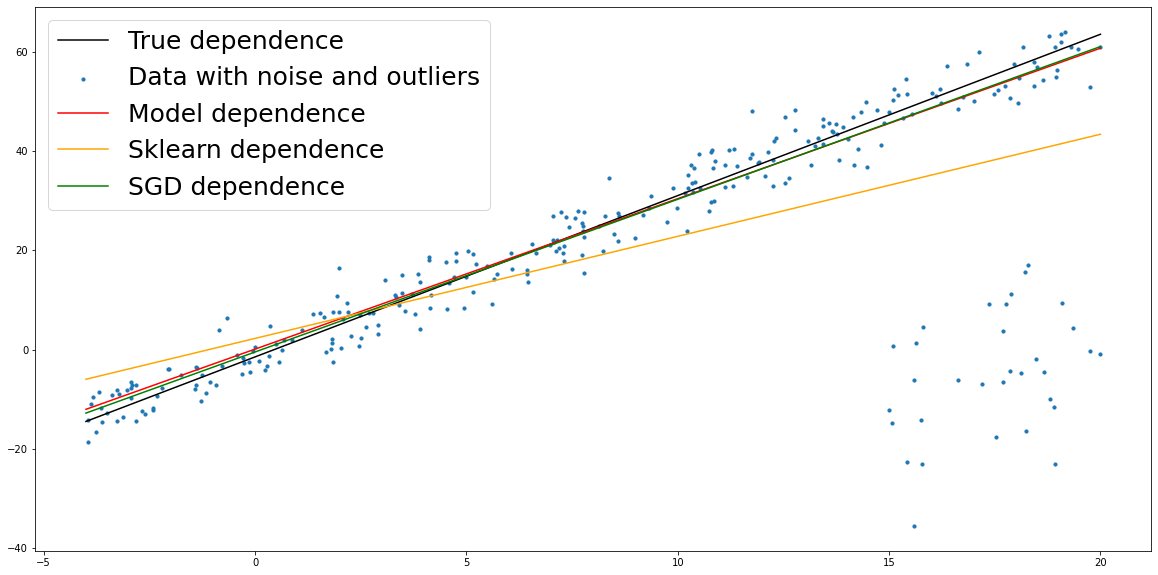

In [13]:
x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(x, predict_function(x), c='red', label='Model dependence')
plt.plot(x, predict_function_sklearn(x), c='orange', label='Sklearn dependence')
plt.plot(x, predict_function_sgd(x), c='green', label='SGD dependence')
plt.legend(loc=2, prop={'size': 25});

### sgd may be slightly better because of decaying lr but cp sgd -> gd for countable steps if sgd or pseudo-gradient meets one condition: the angle between gradient and pseudo-gradient proj is sharp

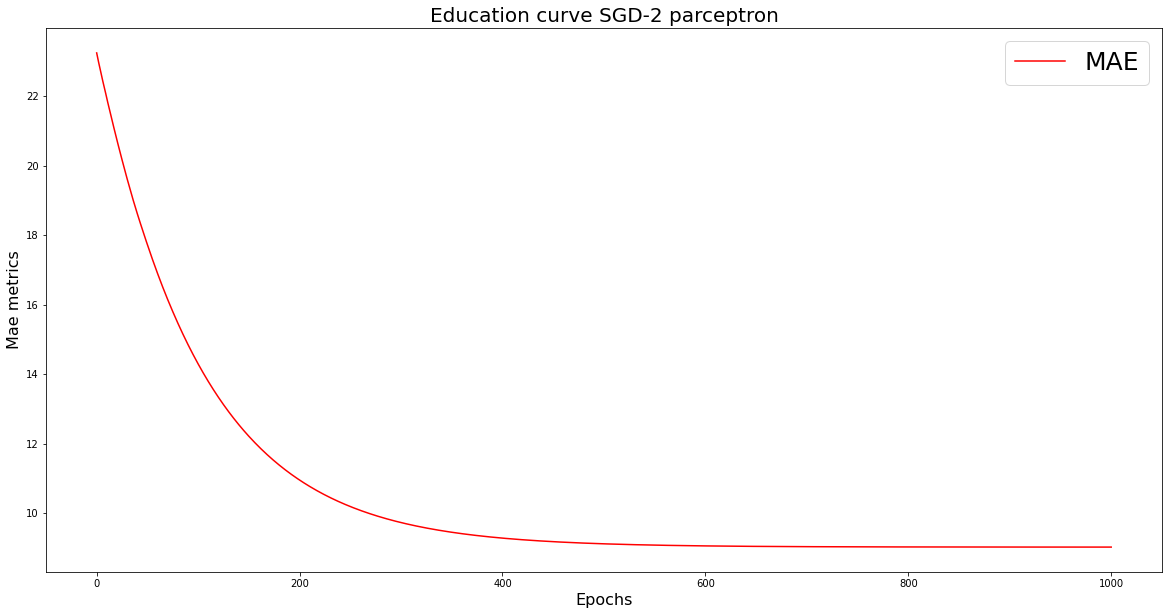

In [14]:
plt.plot(list(range(len(lrsgd.cost_))), lrsgd.cost_, c='red', label='MAE')
plt.title("Education curve SGD-2 parceptron")
plt.xlabel("Epochs")
plt.ylabel("Mae metrics")
plt.legend(loc=1, prop={'size': 25})
plt.show()